
# Understanding f-divergences

An [*f-divergence*](https://en.wikipedia.org/wiki/F-divergence) is a function $D_f(P ~||~ Q)$ that measures the difference between two probability distributions $P$ and $Q$. f-divergences take on values on the range $[0, \infty)$, where $D_f(P ~||~ Q) = 0$ i.f.f. $P$ and $Q$ are identical. f-divergence generalizes KL-divergence (among other divergences).

More formally, consider probabilitiy distributions $P$ and $Q$ both defined over a space $\Omega$.
A convex function $f(t) : \mathbb{R} \to \mathbb{R}; f(1) = 0$ defines an f-divergence;

$$
D_f(P ~||~ Q) := \int_\Omega f \left( \frac{dP}{dQ} \right) dQ
$$

Note that f-divergences are not symmetric, and are not proper metrics (but can sometimes be modified to achieve this).


In [1]:

%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import itertools as it
import scipy.stats as st
import ipywidgets as widgets
import matplotlib.pyplot as plt

from bokeh import plotting as bkplt
from bokeh.io import push_notebook
from bokeh.models import ColumnDataSource

sns.set()



## Side note: Odds and Odds Ratios

Wikipedia asserts we can intuitively think of f-divergences as a average over $\Omega$, weighted by $f$, of the odds ratio between $P$ and $Q$.
**It's not clear to me what this statement means - e.g. what does it mean to talk about the odds ratio between probability distributions, rather than between probabilities of events?**

---

Consider two events $A$ and $B$ with probabilities $p(A)$ and $p(B)$.

The *odds* of event $A$ is $p(A) / (1 - p(A))$, and likewise for $B$.
Odds take on values on the range $[0, \infty)$.

The [*odds ratio*](https://en.wikipedia.org/wiki/Odds_ratio) quantifies the strength of association between $A$ and $B$ and is a value on the range $(0, \infty)$.

$$
OR(p(A), p(B)) = \frac{
    \text{odds of A}
}{
    \text{odds of B}
} = \frac{
    p(A) / (1 - p(A))
}{
    p(B) / (1 - p(B))
} = \frac{
    p(A) \times (1 - p(B))
}{
    p(B) \times (1 - p(A))
}
$$

Note that the odds ratio is symmetric and does not make any statement about causality.

If the OR is 1, then the events are independant; $OR = 1 \implies A \bot B$.

$OR < 1$ implies negative correlation between the events (one event occuring reduces the likelihood of the other), while $OR > 1$ implies positive correlation between the events.


C:\Users\uqasnosw\AppData\Local\Continuum\miniconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\uqasnosw\AppData\Local\Continuum\miniconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


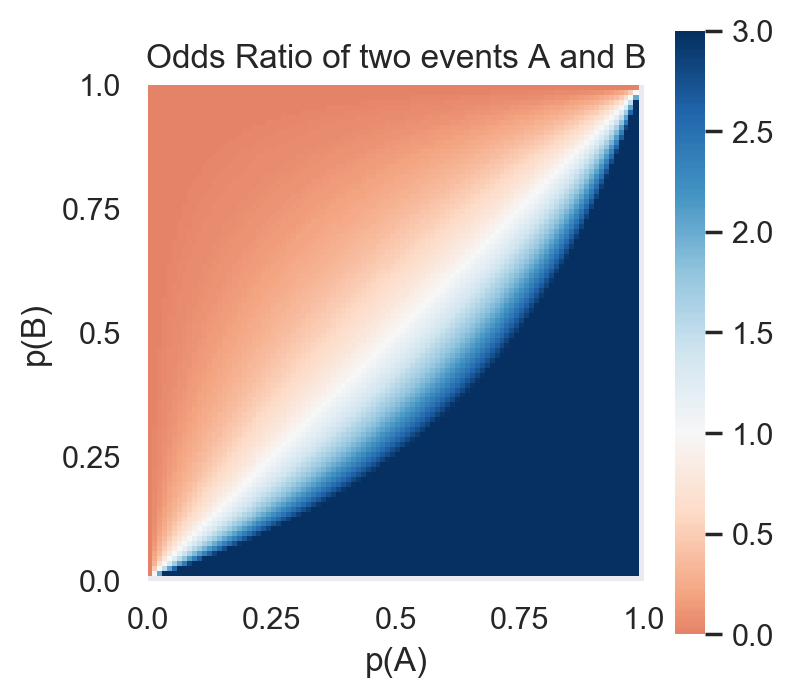

In [2]:

# Plot odds ratio for two events
odds_ratio = lambda pa, pb: (pa * (1 - pb)) / (pb * (1 - pa))

num_pts = 100
mx, my = np.meshgrid(
    np.linspace(0, 1, num_pts),
    np.linspace(0, 1, num_pts)
)
mz = odds_ratio(mx, my)

plt.figure(figsize=(4, 4), dpi=200)
sns.heatmap(
    mz,
    square=True,
    vmin=0,
    center=1,
    vmax=3,
    cmap='RdBu'
)
plt.xticks(np.linspace(0, num_pts, 5), np.linspace(0, 1, 5))
plt.yticks(np.linspace(0, num_pts, 5), np.linspace(0, 1, 5))
plt.gca().invert_yaxis()
plt.xlabel("p(A)")
plt.ylabel("p(B)")
plt.title("Odds Ratio of two events A and B")
plt.show()



Back to f-divergences. Let's look at an example.

## Example: KL-Divergence

For example, consider the KL-Divergence for continuous distributions;

$$
D_\text{KL}(P ~||~ Q) = \int_{\Omega} \log \frac{dP}{dQ} dP
$$

or discrete distributions;

$$
\begin{align}
    D_\text{KL}(P ~||~ Q) &= \sum_{x \in \Omega} P(x) \log \frac{P(x)}{Q(x)}
    \\
    &= \sum_{x \in \Omega} P(x) \left[ \log P(x) - \log Q(x) \right]
\end{align}
$$

We can see this is a special case of an f-divergence, with the choice of $f(t) = t \log t$. Conceptually, we are weighting the log difference between $P(x)$ and $Q(x)$ by some function, in this case, $P(x)$.

## Optimization Context

When f-divergences are used in optimization contexts, we typically assume $P$ is some fixed 'true' distribution that we are trying to approximate with $Q$, which is parameterized by some $\theta$.
The divergence is then used to adjust the parameters of $Q$ until we closely match $P$.

$$
\theta^* = \underset{\theta}{\operatorname{arg min}} D_f(P ~||~ Q)
$$

In this context $D_\text{KL}(P ~||~ Q)$ (P fixed) is called the forward-KL objective, while $D_\text{KL}(Q ~||~ P)$ (P fixed) is called the reverse-KL objective. Note that the reverse-KL can be considered an f-divergence with $f(t) = -\log(t)$.

Forward KL corresponds to weighting the log-difference in the distributions with $P$, while reverse-KL corresponds to weighting by $Q$. What does this difference imply?

We explore this with a simple example;



## Interactive Example

Consider two distributions;

$$
P \sim 0.25 \times \mathcal{N}(-3, 1) + 0.75 \times \mathcal{N}(3, 1)
$$

$$
Q \sim \mathcal{N}(\mu, \sigma)
$$

And let $\theta = (\mu, \sigma)^\top$. Note that $P$ has multiple modes, while $Q$ is unimodal.

Starting from a random initialization, we wish to find a $\theta$ such that $Q$ closely matches $P$.

In the below example (**provided this notebook is actually running, and not a static html file**), you can interactively adjust the sliders for the mean and standard deviation of $Q$. Try to manually optimize for a minimum reverse or forward KL.


In [3]:

# Define our distributions
p = lambda x: 0.25 * st.norm(-3.0).pdf(x) + 0.75 * st.norm(3.0).pdf(x)
q = lambda x, mu, sigma: st.norm(loc=mu, scale=sigma).pdf(x)

# Numerically integrate to approximate KLs on demand
x_bound = 15
fkl = lambda mu, sigma: sp.integrate.quad(
        lambda x: p(x) * (np.log(p(x)) - np.log(q(x, mu, sigma))),
        -x_bound,
        x_bound
    )[0]
rkl = lambda mu, sigma: sp.integrate.quad(
        lambda x: q(x, mu, sigma) * (np.log(q(x, mu, sigma)) - np.log(p(x))),
        -x_bound,
        x_bound
    )[0]

x = np.linspace(-x_bound, x_bound, 500)
p_source = ColumnDataSource(
    data=dict(
        x=x,
        y=p(x)
    )
)
q_source = ColumnDataSource(
    data=dict(
        x=x,
        y=q(x, 0, 1)
    )
)

bkplt.output_notebook()
fig = bkplt.figure(
    title="Visualizing KL Divergence",
    x_axis_label='x',
    y_axis_label='p(x), q(x)',
    x_range=(-x_bound, x_bound),
    y_range=(-0.1, 0.8),
    plot_height=400
)
fig.line('x', 'y', source=p_source, legend_label="P ~ 0.25 N(-3, 1) + 0.75 N(3, 1)", line_width=2, color='red')
fig.line('x', 'y', source=q_source, legend_label="Q ~ N(μ, σ)", line_width=2)

bkplt.show(fig, notebook_handle=True)

@widgets.interact(
    mean=widgets.FloatSlider(min=-x_bound, max=x_bound, step=1.0, value=0.0, continuous_update=False),
    std=widgets.FloatSlider(min=0.6, max=4, step=0.1, value=1.0, continuous_update=False)
)
def update(mean=0.0, std=1.0):
    q_source.data = dict(
        x=x,
        y=q(x, mean, std)
    )
    push_notebook(fig)
    print("Forward-KL: {:0.2f} Reverse-KL: {:0.2f}".format(fkl(mean, std), rkl(mean, std)))


Loading BokehJS ...

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='mean', max=15.0, min=-15.0,…


The minimum attainable forward KL (0.48) occurs at $\mu \approx 2.0, \sigma \approx 3.0$, while the minimum attainable reverse KL (0.29) occurs at $\mu \approx 3.0, \sigma \approx 1.0$. Note that there is also a local minima reverse KL (1.38) at $\mu = -3.0, \sigma = 1.0$.


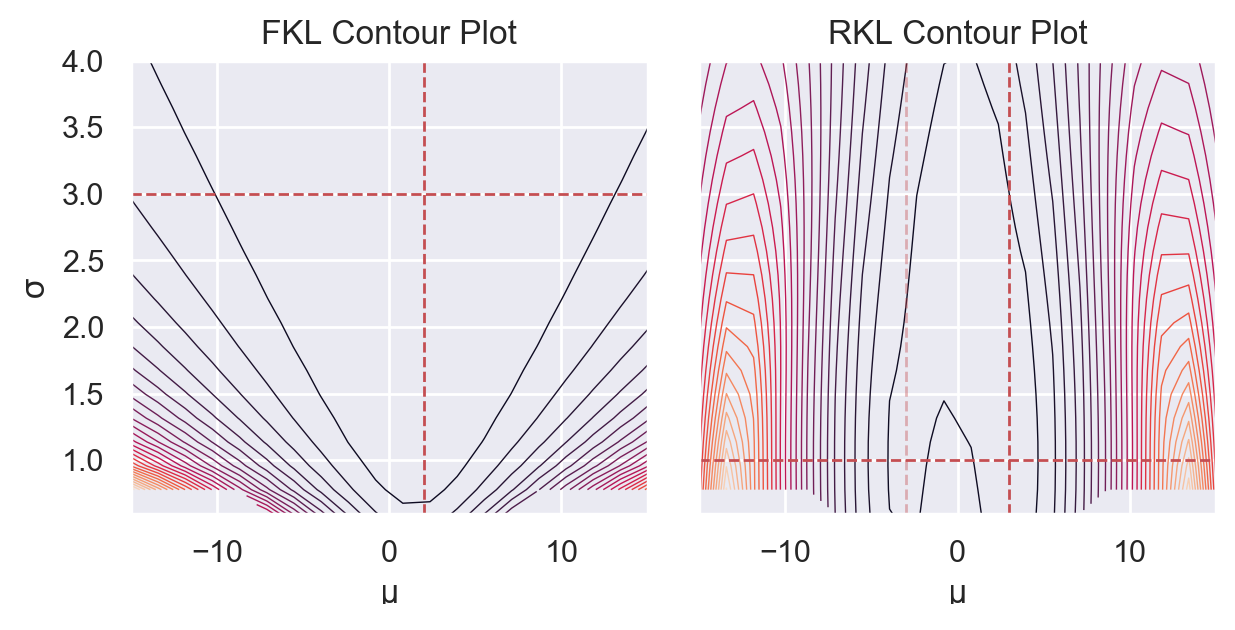

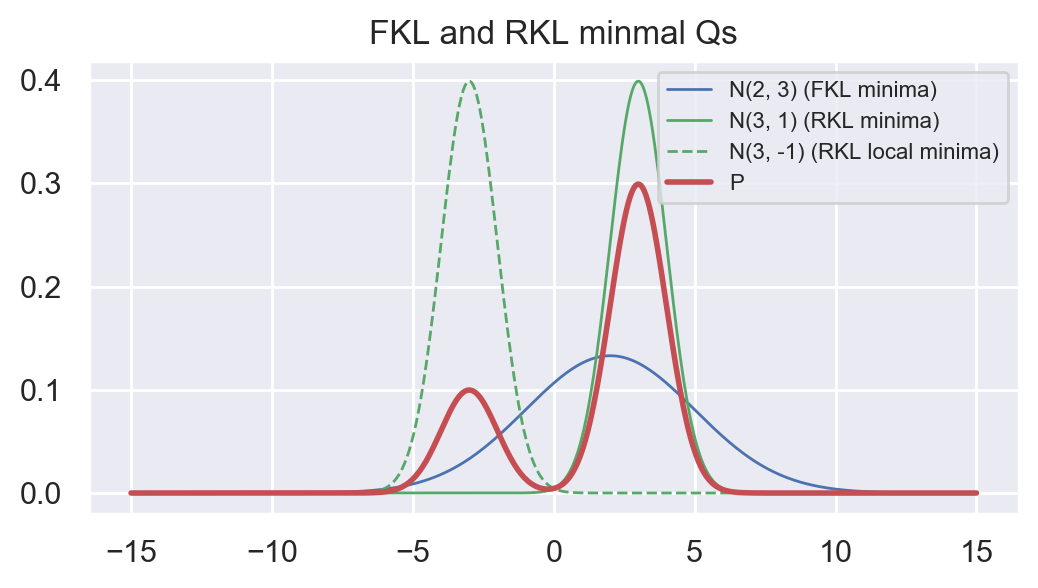

In [4]:

# # Generate dense sampling of parameter space
# steps = 20
# dmu = np.linspace(-15, 15, steps)
# dsigma = np.linspace(0.6, 4, steps)
# mg = np.meshgrid(dmu, dsigma)
# fkl_grid = []
# rkl_grid = []
# for i, (m, s) in enumerate(it.product(dmu, dsigma)):
#     print("{}/{}".format(i, steps*steps))
#     fkl_grid.append(fkl(m, s))
#     rkl_grid.append(rkl(m, s))

# Load pre-computed FKL, RKL sweeps
df_fkl = pd.read_pickle("fkl_longform.pkl")
df_rkl = pd.read_pickle("rkl_longform.pkl")
dmu = sorted(list(set(df_fkl['mu'])))
dsigma = sorted(list(set(df_fkl['sigma'])))
steps = len(dmu)
fkl_grid = df_fkl['fkl']
rkl_grid = df_rkl['rkl']

# Plot forward, reverse KL
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
    gridspec_kw=dict(
        wspace=0.1
    ),
    figsize=(7, 3),
    dpi=200,
)

plt.sca(ax1)
plt.contour(dmu, dsigma, np.array(fkl_grid).reshape(steps, steps).T, 30, linewidths=0.5)
plt.axvline(2, ls='--', color='r', lw=1)
plt.axhline(3, ls='--', color='r', lw=1)
plt.ylabel('σ')
plt.xlabel('μ')
ax1.title.set_text("FKL Contour Plot")

plt.sca(ax2)
plt.contour(dmu, dsigma, np.array(rkl_grid).reshape(steps, steps).T, 30, linewidths=0.5)
plt.axvline(3, ls='--', color='r', lw=1)
plt.axhline(1, ls='--', color='r', lw=1)
plt.axvline(-3, ls='--', color='r', lw=1, alpha=0.4)
plt.xlabel('μ')
ax2.title.set_text("RKL Contour Plot")

plt.show()

# Plot the minima points
plt.figure(figsize=(6, 3), dpi=200)
plt.plot(x, q(x, 2, 3), 'b-', label='N(2, 3) (FKL minima)', lw=1)
plt.plot(x, q(x, 3, 1), 'g-', label='N(3, 1) (RKL minima)', lw=1)
plt.plot(x, q(x, -3, 1), 'g--', label='N(3, -1) (RKL local minima)', lw=1)
plt.plot(x, p(x), 'r-', label='P', lw=2)
plt.legend(fontsize=8)
plt.title("FKL and RKL minmal Qs")
plt.show()



What we observe is that minimizing forward-KL (weighting by $P$) leads to *mode-covering* behaviour - $Q$ will be adjusted to try and have some mass wherever a mode of $P$ exists, because we are weighting the cost by $P$.
This is also known as *zero-avoiding* because the optimization will avoid $Q(x) = 0$ whenever $P(x) > 0$.

On the contrary, minimizing reverse-KL (weighting by $Q$) leads to *mode-seeking* behaviour - $Q$ will be adjusted to ensure that any $Q(x) > 0$ co-incides with $P(x) > 0$, thus seeking out a mode in $P$.
Which mode is selected will depend on the optimization procedure and initialisation.
This is also known as *zero-forcing*, because we may force $Q(x)$ to be 0 for some $P(x) > 0$.

A good discussion of these two cases can be found [here](https://wiseodd.github.io/techblog/2016/12/21/forward-reverse-kl/).

---

Why does any of this matter?
If we care about the likelihood of samples from $Q$ under $P$, then we should probably consider the reverse-KL optimization, as we are guaranteed that at convergence, our $Q$ will cover high-likelihood areas of $P$.

In Inverse Reinforcement Learning, we try to match the distribution of states/actions demonstrated by an expert demonstrator ($P$) with a sampled distribution ($Q$) from a policy that is optimal wrt. our current estimated reward parameters.
Thus, minimizing the reverse-KL divergence might lead to better IRL model performance.
